1- SETUP: IMPORTAÇÃO DE BIBLIOTECAS E CARREGAMENTO DOS DADOS


In [ ]:
import pandas as pd
import numpy as np

print("Carregando os arquivos CSV...")

# Carregando cada arquivo em um DataFrame do Pandas
# O 'delimiter=';' é crucial pois os arquivos não usam vírgula como separador
df_players = pd.read_csv('PicMoney-Base_Cadastral_de_Players-10_000 linhas (1).csv', delimiter=';')
df_transacoes = pd.read_csv('PicMoney-Base_de_Transa__es_-_Cupons_Capturados-100000 linhas (1).csv', delimiter=';')
df_pedestres = pd.read_csv('PicMoney-Base_Simulada_-_Pedestres_Av__Paulista-100000 linhas (1).csv', delimiter=';')
df_massa_teste = pd.read_csv('PicMoney-Massa_de_Teste_com_Lojas_e_Valores-10000 linhas (1).csv', delimiter=';')

print("Arquivos carregados com sucesso!")


Carregando os arquivos CSV...
Arquivos carregados com sucesso!


2- FUNÇÕES GERAIS DE LIMPEZA

In [ ]:
# Função para corrigir as coordenadas (latitude/longitude) que estão em formato inválido
def corrigir_coordenadas(coord_str):
    """
    Remove todos os pontos da string, exceto o primeiro,
    e a converte para um número float.
    Exemplo: '-23.567.430.342.750.400' -> -23.567430342750400
    """
    try:
        # Remove todos os pontos da string
        partes = str(coord_str).replace('.', '')
        # Insere o ponto decimal após o -23 ou -46, etc.
        if partes.startswith('-'):
             # Mantém o sinal e insere o ponto na posição correta
            return float(partes[:3] + '.' + partes[3:])
        else: # Caso não tenha sinal
            return float(partes[:2] + '.' + partes[2:])
    except (ValueError, TypeError):
        # Retorna NaN se a conversão falhar
        return np.nan

3- LIMPEZA DO DATAFRAME DE PLAYERS (df_players)

In [ ]:
print("\nIniciando limpeza da base de Players...")

# Converter 'data_nascimento' para o formato datetime
df_players['data_nascimento'] = pd.to_datetime(df_players['data_nascimento'], format='%d/%m/%Y', errors='coerce')

# Preencher dados faltantes de trabalho e escola com 'Não Informado'
cols_para_preencher = ['cidade_trabalho', 'bairro_trabalho', 'cidade_escola', 'bairro_escola']
df_players[cols_para_preencher] = df_players[cols_para_preencher].fillna('Não Informado')

print("Limpeza da base de Players finalizada.")


Iniciando limpeza da base de Players...
Limpeza da base de Players finalizada.


4- LIMPEZA DO DATAFRAME DE TRANSAÇÕES (df_transacoes)


In [ ]:
print("\nIniciando limpeza da base de Transações...")

# Unir 'data' e 'hora' em uma única coluna datetime
df_transacoes['data_hora_captura'] = pd.to_datetime(df_transacoes['data'] + ' ' + df_transacoes['hora'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df_transacoes = df_transacoes.drop(columns=['data', 'hora']) # Remove as colunas antigas

# Preencher dados faltantes na coluna 'produto'
df_transacoes['produto'] = df_transacoes['produto'].fillna('Não Aplicável')

# CORREÇÃO CRÍTICA: Mapear estabelecimentos para categorias corretas
# Esta é a parte mais importante, pois os dados originais estão muito inconsistentes.
mapeamento_categorias = {
    'Pão de Açúcar': 'Supermercados e Hipermercados', 'Extra Mercado': 'Supermercados e Hipermercados',
    'Habib\'s': 'Restaurantes e Gastronomia', 'Outback': 'Restaurantes e Gastronomia', 'Subway': 'Restaurantes e Gastronomia', 'Octavio Café': 'Restaurantes e Gastronomia',
    'Smart Fit': 'Academias e Esportes',
    'Ponto Frio': 'Lojas de Departamentos e Variedades', 'Lojas Americanas': 'Lojas de Departamentos e Variedades',
    'Renner': 'Moda e Vestuário', 'Riachuelo': 'Moda e Vestuário', 'Havaianas': 'Moda e Vestuário',
    'Drogaria São Paulo': 'Farmácias e Drogarias',
    'Kalunga': 'Papelarias e Livrarias', 'Livraria Cultura': 'Papelarias e Livrarias',
    'Fast Shop': 'Lojas de Eletrônicos e Games', 'Magazine Luiza': 'Lojas de Eletrônicos e Games',
    'Daiso Japan': 'Lojas de Departamentos e Variedades',
    'Cacau Show': 'Alimentação e Docerias'
    # Adicionar outros mapeamentos conforme necessário
}
# Aplica o mapeamento. Se uma loja não estiver no dicionário, mantém a categoria original (que pode ser investigada depois)
df_transacoes['categoria_corrigida'] = df_transacoes['nome_estabelecimento'].map(mapeamento_categorias).fillna(df_transacoes['categoria_estabelecimento'])


print("Limpeza da base de Transações finalizada.")



Iniciando limpeza da base de Transações...
Limpeza da base de Transações finalizada.


5- LIMPEZA DO DATAFRAME DE PEDESTRES (df_pedestres)

In [ ]:
print("\nIniciando limpeza da base de Pedestres...")

# Corrigir as colunas de latitude e longitude usando a função que criamos
df_pedestres['latitude_corrigida'] = df_pedestres['latitude'].apply(corrigir_coordenadas)
df_pedestres['longitude_corrigida'] = df_pedestres['longitude'].apply(corrigir_coordenadas)

# Converter colunas de data e hora
df_pedestres['data_hora_local'] = pd.to_datetime(df_pedestres['data'] + ' ' + df_pedestres['horario'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df_pedestres['data_ultima_compra'] = pd.to_datetime(df_pedestres['data_ultima_compra'], format='%d/%m/%Y', errors='coerce')
df_pedestres = df_pedestres.drop(columns=['data', 'horario']) # Remove as colunas antigas

# Converter 'possui_app_picmoney' para Booleano (True/False)
df_pedestres['possui_app_picmoney'] = df_pedestres['possui_app_picmoney'].apply(lambda x: True if x == 'Sim' else False)

print("Limpeza da base de Pedestres finalizada.")


Iniciando limpeza da base de Pedestres...
Limpeza da base de Pedestres finalizada.


6- LIMPEZA DO DATAFRAME MASSA DE TESTE (df_massa_teste)

In [ ]:
print("\nIniciando limpeza da Massa de Teste...")

# Corrigir as colunas de latitude e longitude
df_massa_teste['latitude_corrigida'] = df_massa_teste['latitude'].apply(corrigir_coordenadas)
df_massa_teste['longitude_corrigida'] = df_massa_teste['longitude'].apply(corrigir_coordenadas)

# Converter data
df_massa_teste['data_captura'] = pd.to_datetime(df_massa_teste['data_captura'], format='%d/%m/%Y', errors='coerce')

print("Limpeza da Massa de Teste finalizada.")


Iniciando limpeza da Massa de Teste...
Limpeza da Massa de Teste finalizada.


 7- INTEGRAÇÃO DOS DADOS (MERGE)

In [ ]:
print("\nIntegrando bases de dados...")

# Vamos enriquecer a base de transações com os dados demográficos dos players
# Usaremos um 'left merge' para manter todas as transações, mesmo que um player não seja encontrado na base de cadastro
df_final = pd.merge(df_transacoes, df_players, on='celular', how='left')

print("Bases integradas com sucesso!")
print("\nVisualização do DataFrame Final Combinado:")
print(df_final.head())
print("\nInformações do DataFrame Final:")
df_final.info()



Integrando bases de dados...
Bases integradas com sucesso!

Visualização do DataFrame Final Combinado:
           celular nome_estabelecimento bairro_estabelecimento  \
0  (61) 96497-8673              Habib's              República   
1  (11) 94231-6424            Smart Fit          Vila Prudente   
2  (11) 97965-2178              Outback               Tucuruvi   
3  (11) 93418-4646               Subway                  Penha   
4  (11) 97973-1725         Octavio Café            Santo Amaro   

                categoria_estabelecimento id_campanha   id_cupom tipo_cupom  \
0            Lojas de Eletrônicos e Games     CAM2768  CUP542835   Cashback   
1            Lojas de Eletrônicos e Games     CAM6679  CUP291620   Cashback   
2   Igrejas e Lojas de Artigos Religiosos     CAM6473  CUP670811    Produto   
3  Fisioterapia e Terapias Complementares     CAM8293  CUP590364    Produto   
4         Clínicas Médicas e Laboratórios     CAM5588  CUP528033    Produto   

         produto  valor_

8- EXPORTAR OS DADOS LIMPOS

In [ ]:
print("\nExportando o DataFrame limpo e integrado para um novo arquivo CSV...")

# Salva o resultado em um novo arquivo CSV que será usado no seu backend
df_final.to_csv('dados_picmoney_limpos_e_integrados.csv', index=False, sep=';', decimal=',')

print("Processo finalizado! O arquivo 'dados_picmoney_limpos_e_integrados.csv' foi criado com sucesso.")



Exportando o DataFrame limpo e integrado para um novo arquivo CSV...
Processo finalizado! O arquivo 'dados_picmoney_limpos_e_integrados.csv' foi criado com sucesso.


In [ ]:
# ==============================================================================
# 1. SETUP: IMPORTAÇÃO DE BIBLIOTECAS E CARREGAMENTO DOS DADOS
# ==============================================================================
import pandas as pd
import numpy as np

print("Iniciando processo completo: Limpeza, Tratamento e Análise.")

try:
    # Carregando cada arquivo em um DataFrame do Pandas
    print("Carregando os arquivos CSV brutos...")
    df_players = pd.read_csv('PicMoney-Base_Cadastral_de_Players-10_000 linhas (1).csv', delimiter=';')
    df_transacoes = pd.read_csv('PicMoney-Base_de_Transa__es_-_Cupons_Capturados-100000 linhas (1).csv', delimiter=';')
    print("Arquivos carregados com sucesso!")

    # ==============================================================================
    # 2. LIMPEZA E PREPARAÇÃO DOS DADOS
    # ==============================================================================
    print("\nIniciando limpeza e tratamento...")

    # --- Limpando Players ---
    df_players['data_nascimento'] = pd.to_datetime(df_players['data_nascimento'], format='%d/%m/%Y', errors='coerce')
    cols_para_preencher = ['cidade_trabalho', 'bairro_trabalho', 'cidade_escola', 'bairro_escola']
    df_players[cols_para_preencher] = df_players[cols_para_preencher].fillna('Não Informado')

    # --- Limpando Transações ---
    df_transacoes['data_hora_captura'] = pd.to_datetime(df_transacoes['data'] + ' ' + df_transacoes['hora'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    df_transacoes = df_transacoes.drop(columns=['data', 'hora'])
    df_transacoes['produto'] = df_transacoes['produto'].fillna('Não Aplicável')

    mapeamento_categorias = {
        'Pão de Açúcar': 'Supermercados e Hipermercados', 'Extra Mercado': 'Supermercados e Hipermercados',
        'Habib\'s': 'Restaurantes e Gastronomia', 'Outback': 'Restaurantes e Gastronomia', 'Subway': 'Restaurantes e Gastronomia', 'Octavio Café': 'Restaurantes e Gastronomia',
        'Smart Fit': 'Academias e Esportes',
        'Ponto Frio': 'Lojas de Departamentos e Variedades', 'Lojas Americanas': 'Lojas de Departamentos e Variedades',
        'Renner': 'Moda e Vestuário', 'Riachuelo': 'Moda e Vestuário', 'Havaianas': 'Moda e Vestuário',
        'Drogaria São Paulo': 'Farmácias e Drogarias',
        'Kalunga': 'Papelarias e Livrarias', 'Livraria Cultura': 'Papelarias e Livrarias',
        'Fast Shop': 'Lojas de Eletrônicos e Games', 'Magazine Luiza': 'Lojas de Eletrônicos e Games',
        'Daiso Japan': 'Lojas de Departamentos e Variedades',
        'Cacau Show': 'Alimentação e Docerias'
    }
    df_transacoes['categoria_corrigida'] = df_transacoes['nome_estabelecimento'].map(mapeamento_categorias).fillna(df_transacoes['categoria_estabelecimento'])

    print("Limpeza finalizada.")

    # ==============================================================================
    # 3. INTEGRAÇÃO DOS DADOS (MERGE)
    # ==============================================================================
    print("\nIntegrando bases de dados...")
    df_final = pd.merge(df_transacoes, df_players, on='celular', how='left')
    print("Bases integradas com sucesso!")

    # ==============================================================================
    # 4. FEATURE ENGINEERING PARA ANÁLISE
    # ==============================================================================
    df_final['dia_da_semana'] = df_final['data_hora_captura'].dt.day_name()
    df_final['hora_do_dia'] = df_final['data_hora_captura'].dt.hour

    bins = [0, 18, 25, 35, 50, 65, 100]
    labels = ['0-18', '19-25', '26-35', '36-50', '51-65', '65+']
    df_final['faixa_etaria'] = pd.cut(df_final['idade'], bins=bins, labels=labels, right=False)

    # ==============================================================================
    # 5. EXECUÇÃO DAS ANÁLISES PARA GERAR OS INSIGHTS
    # ==============================================================================
    print("\n\n--- INÍCIO DA ANÁLISE DE INSIGHTS ---")

    print("\n--- Análise de Perfil do Player ---")
    print("\nDistribuição por Sexo (%):")
    dist_sexo = df_final.drop_duplicates(subset=['celular'])['sexo'].value_counts(normalize=True) * 100
    print(dist_sexo.round(2))

    print("\nDistribuição por Faixa Etária (%):")
    dist_idade = df_final.drop_duplicates(subset=['celular'])['faixa_etaria'].value_counts(normalize=True) * 100
    print(dist_idade.round(2))

    print("\nTop 5 Bairros Residenciais:")
    top_bairros = df_final.drop_duplicates(subset=['celular'])['bairro_residencial'].value_counts().nlargest(5)
    print(top_bairros)

    print("\n--- Análise de Transações e Cupons ---")
    print("\nNúmero de Transações por Dia da Semana:")
    trans_dia_map = {
        "Monday": "Segunda-feira", "Tuesday": "Terça-feira", "Wednesday": "Quarta-feira",
        "Thursday": "Quinta-feira", "Friday": "Sexta-feira", "Saturday": "Sábado", "Sunday": "Domingo"
    }
    trans_dia = df_final['dia_da_semana'].value_counts().rename(index=trans_dia_map)
    print(trans_dia)

    print("\nNúmero de Transações por Hora do Dia:")
    trans_hora = df_final['hora_do_dia'].value_counts().sort_index()
    print(trans_hora)

    print("\nDistribuição de Uso por Tipo de Cupom:")
    uso_cupom = df_final['tipo_cupom'].value_counts()
    print(uso_cupom)

    print("\nAnálise Financeira dos Cupons:")
    receita_total = df_final['valor_compra'].sum()
    custo_total_cupons = df_final['valor_cupom'].sum()
    print(f"Receita Total: R$ {receita_total:,.2f}")
    print(f"Custo Total com Cupons: R$ {custo_total_cupons:,.2f}")
    print(f"Percentual de Custo do Cupom sobre a Receita: {(custo_total_cupons / receita_total) * 100:.2f}%")

    print("\n--- Análise de Lojas e Categorias ---")
    print("\nTop 5 Lojas por Receita (Valor de Compra):")
    top_lojas_receita = df_final.groupby('nome_estabelecimento')['valor_compra'].sum().nlargest(5)
    print(top_lojas_receita)

    print("\nTop 5 Lojas por Número de Transações:")
    top_lojas_transacoes = df_final['nome_estabelecimento'].value_counts().nlargest(5)
    print(top_lojas_transacoes)

    print("\nTop 5 Categorias (Corrigidas) por Receita:")
    top_categorias_receita = df_final.groupby('categoria_corrigida')['valor_compra'].sum().nlargest(5)
    print(top_categorias_receita)

    print("\n--- Análises Cruzadas (Deep Dive) ---")
    print("\nTicket Médio (Valor de Compra) por Faixa Etária:")
    ticket_por_idade = df_final.groupby('faixa_etaria')['valor_compra'].mean().sort_values(ascending=False)
    print(ticket_por_idade.round(2))

    print("\nCategoria mais popular por Sexo (baseado em nº de transações):")
    categoria_por_sexo = df_final.groupby('sexo')['categoria_corrigida'].apply(lambda x: x.value_counts().index[0])
    print(categoria_por_sexo)

    print("\nReceita Total por Dia da Semana:")
    receita_por_dia = df_final.groupby('dia_da_semana')['valor_compra'].sum().sort_values(ascending=False).rename(index=trans_dia_map)
    print(receita_por_dia)

    # ==============================================================================
    # 6. EXPORTAR OS DADOS LIMPOS
    # ==============================================================================
    print("\nExportando o DataFrame limpo e integrado para um novo arquivo CSV...")
    df_final.to_csv('dados_picmoney_limpos_e_integrados.csv', index=False, sep=';', decimal=',')
    print("\nProcesso finalizado! O arquivo 'dados_picmoney_limpos_e_integrados.csv' foi criado com sucesso.")


except FileNotFoundError:
    print("Erro: Um ou mais arquivos CSV brutos não foram encontrados. Certifique-se de que todos os arquivos foram carregados no ambiente do Colab.")
except Exception as e:
    print(f"Ocorreu um erro inesperado durante o processo: {e}")

Iniciando processo completo: Limpeza, Tratamento e Análise.
Carregando os arquivos CSV brutos...
Erro: Um ou mais arquivos CSV brutos não foram encontrados. Certifique-se de que todos os arquivos foram carregados no ambiente do Colab.


Iniciando a geração da análise completa (dados numéricos e gráficos)...


--- ANÁLISE NUMÉRICA ---

Distribuição de Clientes por Faixa Etária:
faixa_etaria
51-65    1
26-35    1
19-25    0
0-18     0
36-50    0
65+      0
Name: count, dtype: int64

Top 5 Bairros por Quantidade de Clientes:
bairro_residencial
Jabaquara    1
Itaquera     1
Name: count, dtype: int64

Total de Transações por Dia da Semana:
dia_da_semana
Saturday     4829
Sunday       3347
Tuesday       412
Wednesday     402
Thursday      391
Monday        325
Friday        294
Name: count, dtype: int64


--- GERANDO GRÁFICOS ---
Salvo: grafico_distribuicao_idade.png


/tmp/ipython-input-2914459456.py:75: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.savefig('grafico_top_bairros_melhorado.png')


Salvo: grafico_top_bairros_melhorado.png
Salvo: grafico_transacoes_dia_semana.png

Processo finalizado com sucesso!


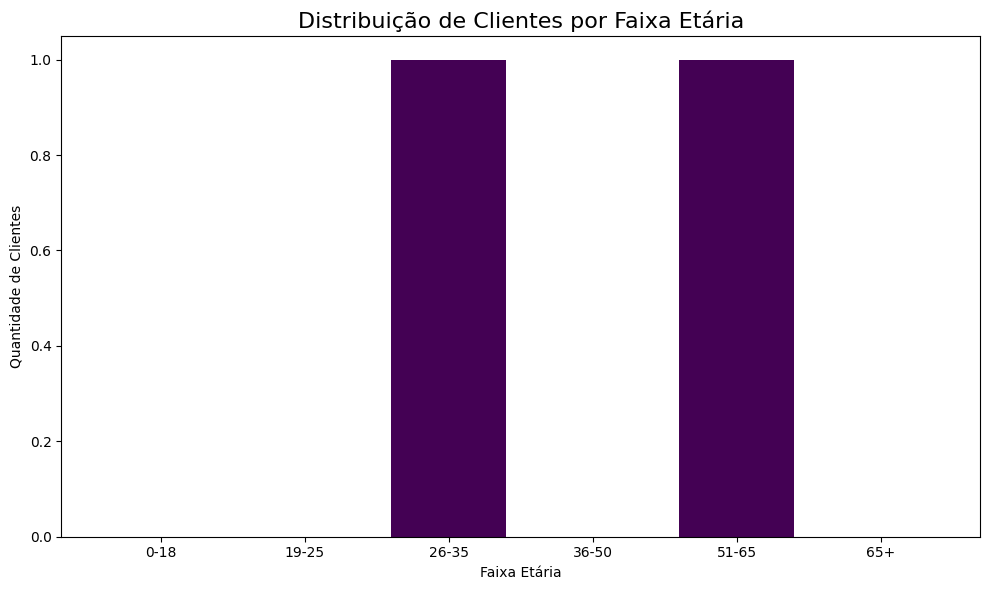

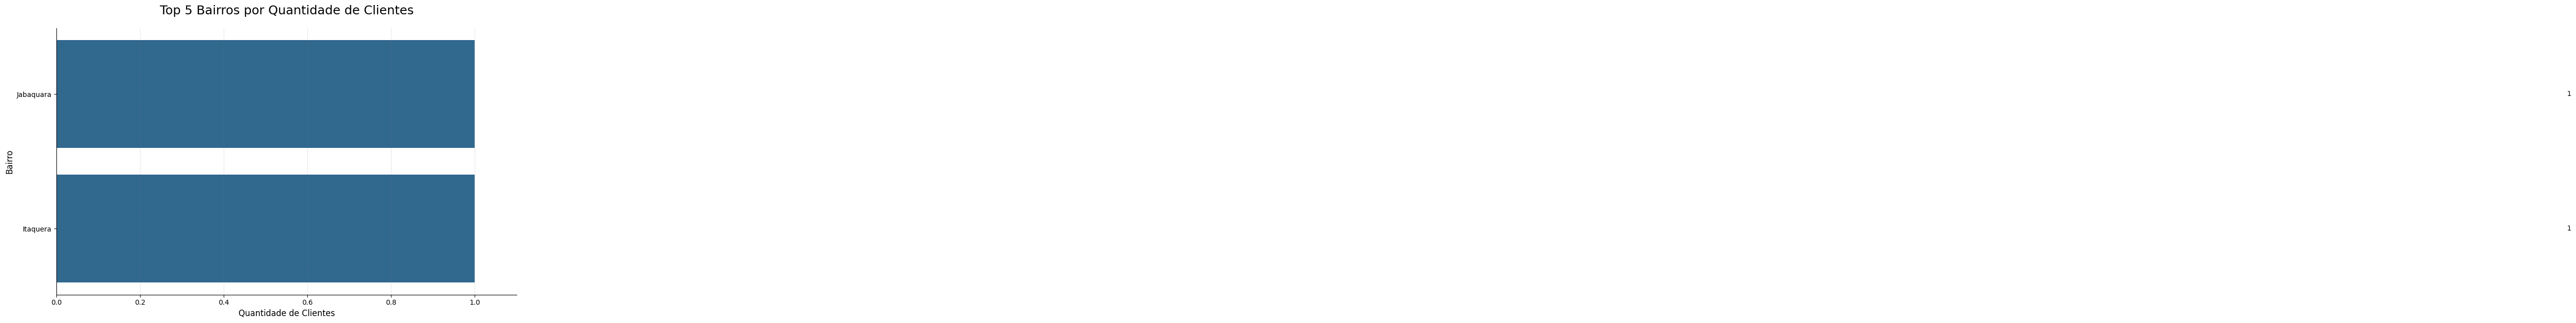

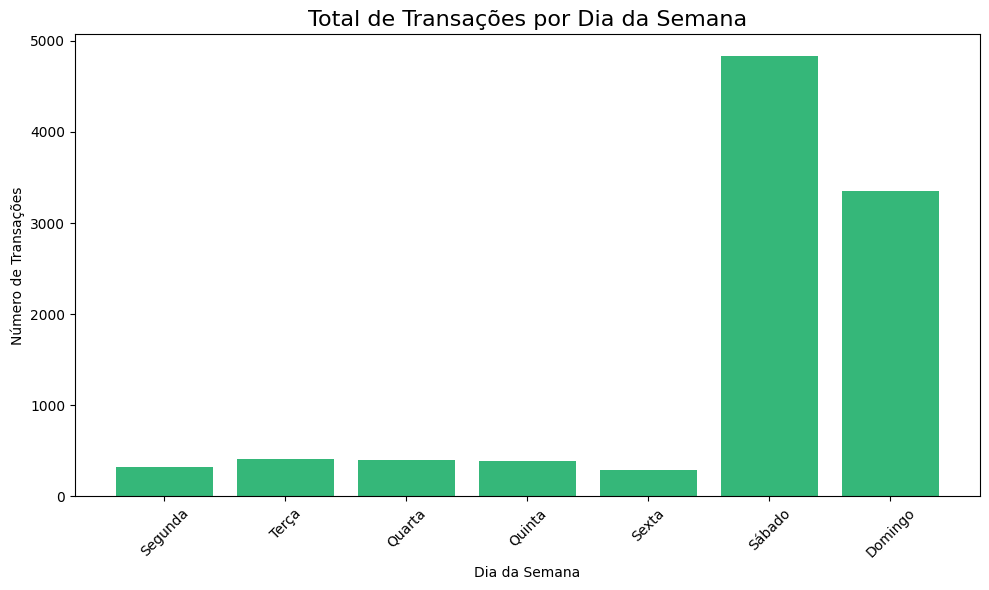

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("Iniciando a geração da análise completa (dados numéricos e gráficos)...")

try:
    # ==============================================================================
    # 1. CARREGAR E PREPARAR OS DADOS CORRETOS
    # ==============================================================================

    # Usaremos a Massa de Teste que contém os valores de compra
    df_transacoes = pd.read_csv('PicMoney-Massa_de_Teste_com_Lojas_e_Valores-10000 linhas (1).csv', delimiter=';')
    # E a base de Players para os dados demográficos
    df_players = pd.read_csv('PicMoney-Base_Cadastral_de_Players-10_000 linhas (1).csv', delimiter=';')

    # Renomear coluna para fazer o merge
    df_transacoes.rename(columns={'numero_celular': 'celular'}, inplace=True)

    # Combinar as duas bases
    df_final = pd.merge(df_transacoes, df_players, on='celular', how='left')

    # ==============================================================================
    # 2. FEATURE ENGINEERING (CRIAR COLUNAS ÚTEIS)
    # ==============================================================================

    df_final['data_captura'] = pd.to_datetime(df_final['data_captura'], format='%d/%m/%Y', errors='coerce')
    df_final['dia_da_semana'] = df_final['data_captura'].dt.day_name()

    bins = [0, 18, 25, 35, 50, 65, 100]
    labels = ['0-18', '19-25', '26-35', '36-50', '51-65', '65+']
    df_final['faixa_etaria'] = pd.cut(df_final['idade'], bins=bins, labels=labels, right=False)

    # ==============================================================================
    # 3. ANÁLISE NUMÉRICA (IMPRESSÃO DOS DADOS)
    # ==============================================================================
    print("\n\n--- ANÁLISE NUMÉRICA ---")

    print("\nDistribuição de Clientes por Faixa Etária:")
    print(df_final.drop_duplicates(subset=['celular'])['faixa_etaria'].value_counts())

    print("\nTop 5 Bairros por Quantidade de Clientes:")
    print(df_final.drop_duplicates(subset=['celular'])['bairro_residencial'].value_counts().nlargest(5))

    print("\nTotal de Transações por Dia da Semana:")
    print(df_final['dia_da_semana'].value_counts())

    # ==============================================================================
    # 4. GERAÇÃO DE GRÁFICOS (SALVAR IMAGENS)
    # ==============================================================================
    print("\n\n--- GERANDO GRÁFICOS ---")

    # GRÁFICO 1: Distribuição de Clientes por Faixa Etária
    plt.figure(figsize=(10, 6))
    idade_counts = df_final.drop_duplicates(subset=['celular'])['faixa_etaria'].value_counts().reindex(labels)
    plt.bar(idade_counts.index, idade_counts.values, color='#440154')
    plt.title('Distribuição de Clientes por Faixa Etária', fontsize=16)
    plt.xlabel('Faixa Etária'); plt.ylabel('Quantidade de Clientes')
    plt.tight_layout(); plt.savefig('grafico_distribuicao_idade.png')
    print("Salvo: grafico_distribuicao_idade.png")

    # GRÁFICO 2: Top 5 Bairros com Mais Clientes (VERSÃO MELHORADA)
    top_5_bairros = df_final.drop_duplicates(subset=['celular'])['bairro_residencial'].value_counts().nlargest(5)
    fig, ax = plt.subplots(figsize=(12, 7))
    bars = ax.barh(top_5_bairros.index, top_5_bairros.values, color='#31688e')
    ax.invert_yaxis()
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 5, bar.get_y() + bar.get_height() / 2, f'{int(width)}', ha='left', va='center')
    ax.set_title('Top 5 Bairros por Quantidade de Clientes', fontsize=18, pad=20)
    ax.set_xlabel('Quantidade de Clientes', fontsize=12); ax.set_ylabel('Bairro', fontsize=12)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
    ax.set_xlim(right=top_5_bairros.max() * 1.1)
    plt.tight_layout(); plt.savefig('grafico_top_bairros_melhorado.png')
    print("Salvo: grafico_top_bairros_melhorado.png")

    # GRÁFICO 3: Transações por Dia da Semana
    dias_ordenados = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    nomes_dias_pt = ["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado", "Domingo"]
    plt.figure(figsize=(10, 6))
    trans_dia_counts = df_final['dia_da_semana'].value_counts().reindex(dias_ordenados)
    plt.bar(nomes_dias_pt, trans_dia_counts.values, color='#35b779')
    plt.title('Total de Transações por Dia da Semana', fontsize=16)
    plt.xlabel('Dia da Semana'); plt.ylabel('Número de Transações')
    plt.xticks(rotation=45)
    plt.tight_layout(); plt.savefig('grafico_transacoes_dia_semana.png')
    print("Salvo: grafico_transacoes_dia_semana.png")

    print("\nProcesso finalizado com sucesso!")

except FileNotFoundError:
    print("Erro: Um ou mais arquivos CSV não foram encontrados.")
    print("Por favor, certifique-se de que os arquivos 'Massa_de_Teste...' e 'Base_Cadastral_de_Players...' estão no ambiente do Colab.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")